In [1]:
import matplotlib.pyplot as plt
import boost_histogram as bh
from tqdm import tqdm
from particle import literals as lp
import joblib  # only joblib works reliably in notebooks
import numpy as np

from chromo.kinematics import CenterOfMass, TeV, MeV
from chromo.constants import long_lived
import chromo.models as im
from chromo.util import pdg2name
import numba as nb
import gzip
import pickle
from pathlib import Path

In [2]:
# The event kinematics objects defines the collision and its frame.
ekin = CenterOfMass(
    2 * 6.8 * TeV,
    "proton",
    "proton"
)

In [3]:
pid_axis = bh.axis.IntCategory([x.pdgid for x in (lp.K_S_0, lp.Lambda, lp.Lambda_bar)])
parent_axis = bh.axis.IntCategory([], growth=True)
pt_axis = bh.axis.Variable([150, 500, 650, 800, 1000, 1200, 2500])
y_axis = bh.axis.Regular(5, 2, 4.5)

models = [
    im.Sibyll23d,
    im.Pythia8,
    im.EposLHC
]

n_events = 10_000


@nb.njit
def select(pids):
    keep = (310, 3122, -3122)
    r = np.zeros_like(pids, dtype="bool")
    for i, pid in enumerate(pids):
        if pid in keep:
            r[i] = True
    return r


@nb.njit
def pid_of_parent(mothers, pids, status):
    r = np.zeros_like(pids)
    for i, mo in enumerate(mothers):
        k = mo[0]
        while k >= 0:
            pid = pids[k]
            if pid in long_lived and status[k] != 4:
                r[i] = pid
                break
            k = mothers[k][0]
    return r


@joblib.delayed
def run(Model):
    m = Model(ekin, seed=1)
    for pid in long_lived:
        m.set_stable(pid, False)
    for p in (lp.pi_0, lp.K_S_0, lp.Lambda):
        m.set_stable(p.pdgid)

    h = bh.Histogram(y_axis, pt_axis, pid_axis, parent_axis)

    with np.errstate(divide="ignore", invalid="ignore"):
        for event in tqdm(m(n_events), total=n_events):
            mother_pid = pid_of_parent(event.mothers, event.pid, event.status)
            mask = select(event.pid)
            event = event[mask]
            mother_pid = mother_pid[mask]
            h.fill(event.y, event.pt / MeV, event.pid, mother_pid)

    return m.label, h

# cache result to disk
fn = Path("feed_down_histograms.pkl.gz")
if not fn.exists():
    with joblib.Parallel(n_jobs=10, batch_size=1) as pool:
        results = pool(run(m) for m in models)

    results = {label: h for (label, h) in results}

    with gzip.open(fn, "w") as f:
        pickle.dump(results, f)
else:
    with gzip.open(fn) as f:
        results = pickle.load(f)

 |                                                  |
 |                 S I B Y L L  2.3d                |
 |                                                  |
 |         HADRONIC INTERACTION MONTE CARLO         |
 |                        BY                        |
 |            Eun-Joo AHN, Felix RIEHN              |
 |      R. ENGEL, A. FEDYNITCH, R.S. FLETCHER,      |
 |       T.K. GAISSER, P. LIPARI, T. STANEV         |
 |                                                  |
 | Publication to be cited when using this program: |
 | Eun-Joo AHN et al., Phys.Rev. D80 (2009) 094003  |
 | F. RIEHN et al., hep-ph: 1912.03300              |
 | last modifications: F. Riehn (05/20/2020)        |

###################################################################
#        EPOS LHC      K. WERNER, T. PIEROG                       #
#                      Contact: tanguy.pierog@kit.edu             #
###################################################################
#        WARNING: This is

100%|██████████| 10000/10000 [03:46<00:00, 44.12it/s]


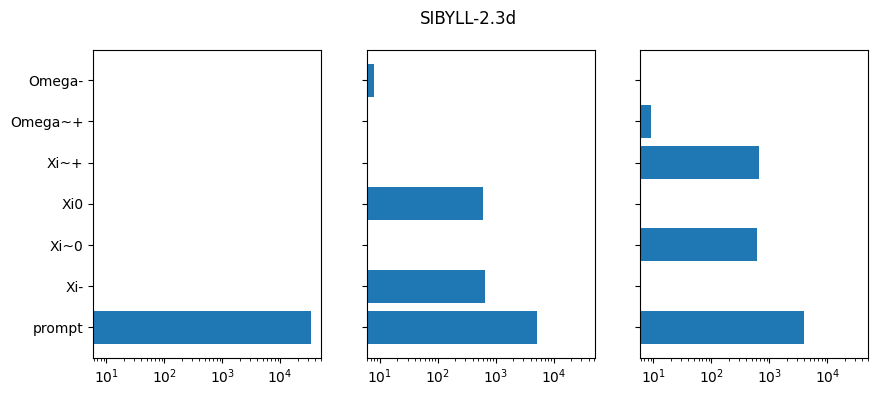

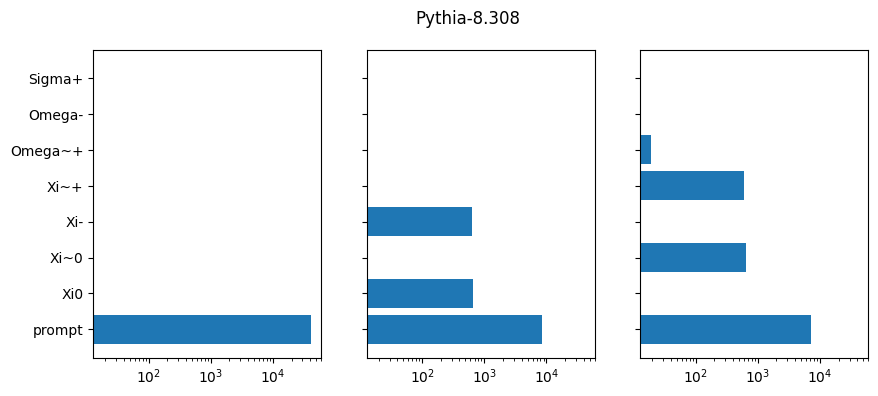

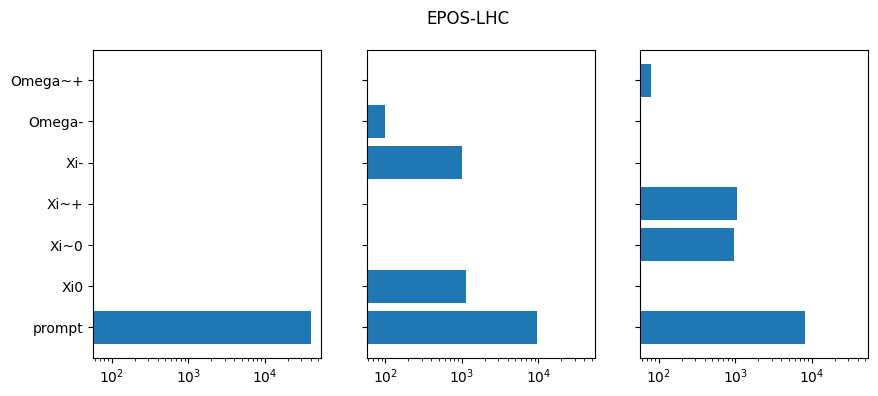

In [8]:
for model, h in results.items():
    val = h.project(2, 3).values()
    fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
    plt.suptitle(model)
    for i, pid in enumerate(h.axes[2]):
        plt.sca(ax[i])
        plt.barh(h.axes[3].edges[:-1], val[i])
        plt.yticks(h.axes[3].edges[:-1], [pdg2name(pid) if pid != 0 else "prompt" for pid in h.axes[3]])
    plt.semilogx()

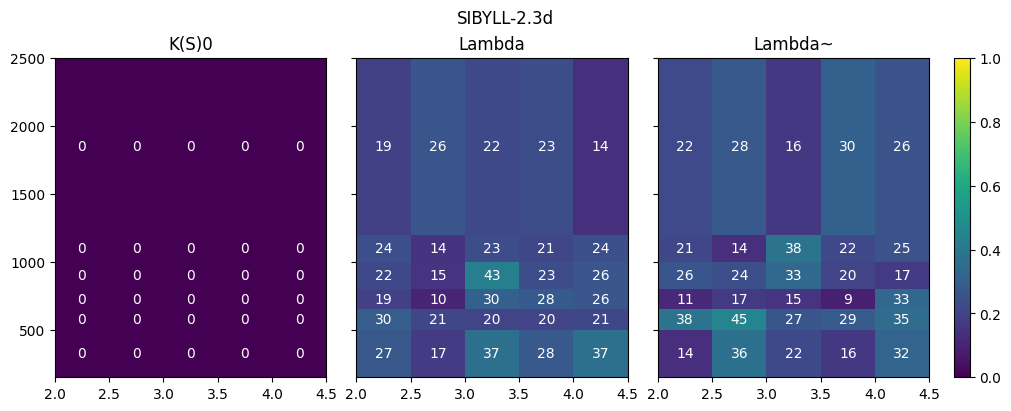

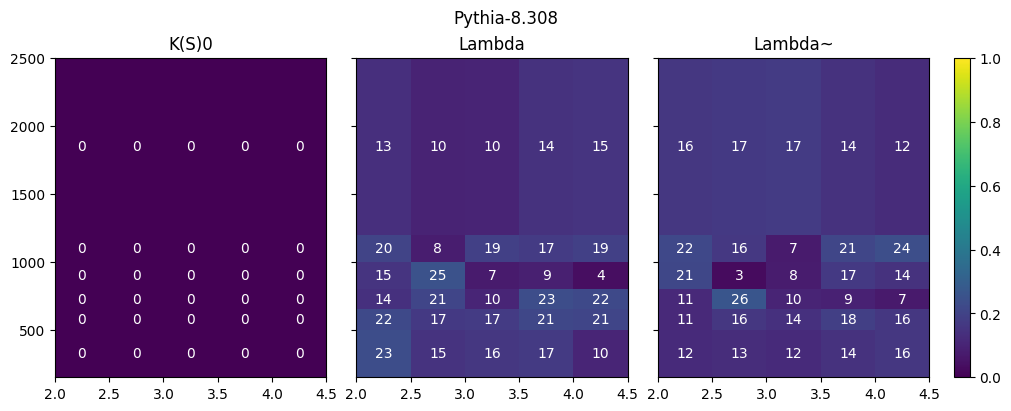

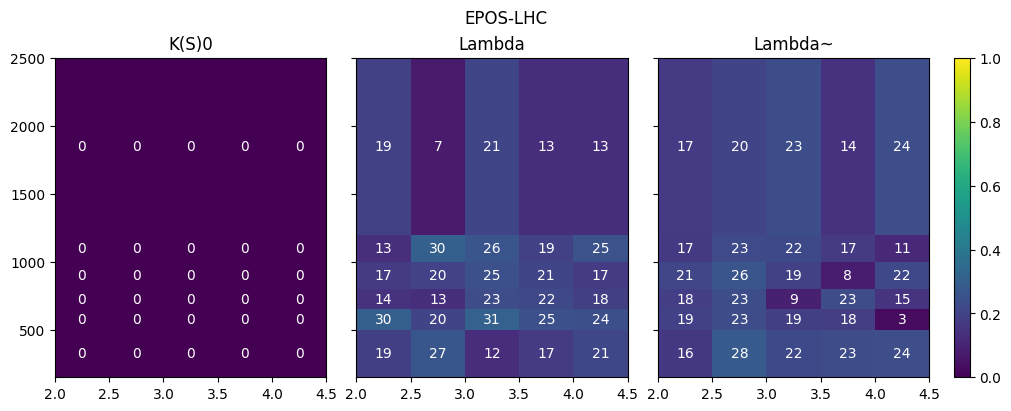

In [9]:
for model, h in results.items():
    fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True, layout="compressed")
    plt.suptitle(model)
    for i, pid in enumerate(h.axes[2]):
        plt.sca(ax[i])
        plt.title(pdg2name(pid))
        val = h.values()[:, :, i, :]
        n_total = np.sum(val, axis=-1)
        n_prompt = val[..., h.axes[3].index(0)]
        feed_down_fraction = 1 - n_prompt / n_total
        plt.pcolormesh(h.axes[0].edges, h.axes[1].edges, feed_down_fraction.T)
        for i, x in enumerate(h.axes[0].centers):
            for j, y in enumerate(h.axes[1].centers):
                f = feed_down_fraction[i, j]
                plt.text(x, y, f"{f*100:.0f}", color="w", ha="center", va="center")
        plt.clim(0, 1)
    plt.colorbar()
